In [1]:
import numpy as np
from qclib.gates.ldmcu import Ldmcu
from qclib.gates.ldmcu_approx import LdmcuApprox
from qiskit import QuantumRegister, QuantumCircuit, transpile
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt
from qclib.util import get_cnot_count

In [2]:
unitary = np.array([[0,1], [1,0]])
error = 1*10**(-4)

ldmcu_approx_test = LdmcuApprox(unitary, num_controls=100, error=error)
base_ctrl_qubits = ldmcu_approx_test._get_num_base_ctrl_qubits(unitary, error)

num_control = 10

controls_base = QuantumRegister(num_control)
target = QuantumRegister(1)

print('Com error = %.6f, o circuito terá %d controles' %(error, base_ctrl_qubits))

Com error = 0.000100, o circuito terá 15 controles


## Circuito real

In [3]:
control_real = QuantumRegister(10)
circuit_1 = QuantumCircuit(control_real, target)
Ldmcu.ldmcu(circuit_1, unitary, control_real, target)

In [4]:
# numero de controles fixado

In [5]:
matrix_circ_1 = Operator(circuit_1).data

In [6]:
matrix_circ_1

array([[ 1.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  1.00000000e+00-5.68555619e-16j,
         0.00000000e+00+0.00000000e+00j, ...,
         7.59955684e-34+2.35761473e-35j,  0.00000000e+00+0.00000000e+00j,
         1.19594414e-19-3.66912218e-22j],
       [ 0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         1.00000000e+00-5.68555619e-16j, ...,
         0.00000000e+00+0.00000000e+00j,  0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j],
       ...,
       [ 0.00000000e+00+0.00000000e+00j, -7.59609145e-34-3.29001974e-35j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.00000000e+00-2.49800181e-15j,  0.00000000e+00+0.00000000e+00j,
        -1.19594414e-19+3.89815960e-17j],
       [ 0.00000000e+00+0.00000000e+00j,  0.

## Circuito approx

In [7]:
circuit_2 = QuantumCircuit(controls_base, target)
LdmcuApprox.ldmcu_approx(circuit_2, unitary, controls_base, target, error)

Exception: The number of control qubits is too low

In [ ]:
matrix_circ_2 = Operator(circuit_2).data

In [ ]:
matrix_circ_2

$$a_{tol} = \parallel a - b \parallel - \, r_{tol} * \parallel b \parallel$$

In [ ]:
np.allclose(matrix_circ_1, matrix_circ_2, atol=0.1)

In [ ]:
ldmcut = transpile(circuit_1, basis_gates=['u', 'cx'])
ldmcu_approxt = transpile(circuit_2, basis_gates=['u', 'cx'])

ldmcu_ops = ldmcut.count_ops()
ldmcu_approx_ops = ldmcu_approxt.count_ops()

In [ ]:
print(ldmcu_ops['cx'])

In [ ]:
print(ldmcu_approx_ops['cx'])

## Gráfico ldmcu vs Lmdcu_approx

In [19]:
def circuits(unitary, error, base_ctrl_q, max_contrl_q):

    target = QuantumRegister(1)
    real_circuit = []
    approx_circuit = []
    n_controls_approx = []
    for size in range(base_ctrl_q, max_contrl_q):
        controls_base = QuantumRegister(size)

        # faz append do numero de Cnots do circuito real.
        circuit_1 = QuantumCircuit(controls_base, target)
        Ldmcu.ldmcu(circuit_1, unitary, controls_base, target)
        ldmcut = transpile(circuit_1, basis_gates=['u', 'cx'])
        ldmcu_ops = ldmcut.count_ops()
        n_cnot_real = ldmcu_ops['cx']
        real_circuit.append(n_cnot_real)

        # faz append do numero de Cnots circuito aproximado.
        circuit_2 = QuantumCircuit(controls_base, target)
        LdmcuApprox.ldmcu_approx(circuit_2, unitary, controls_base, target, error)
        ldmcu_approxt = transpile(circuit_2, basis_gates=['u', 'cx'])
        ldmcu_approx_ops = ldmcu_approxt.count_ops()
        n_cnot_approx = ldmcu_approx_ops['cx']
        if True: #n_cnot_approx <= n_cnot_real:
            approx_circuit.append(ldmcu_approx_ops['cx'])
            #n_controls_approx.append(size)

    return real_circuit, approx_circuit #, n_controls_approx

In [20]:
unitary = np.array([[0,1], [1,0]])
error = 10e-4
#ldmcu_approx_test = LdmcuApprox(unitary, num_controls=100, error=error)
base_ctrl_qubits = ldmcu_approx_test._get_num_base_ctrl_qubits(unitary, error)

In [21]:
base_ctrl_q = base_ctrl_qubits
max_contrl_q = base_ctrl_qubits + 40
control_qubits = np.arange(base_ctrl_q, max_contrl_q)

In [22]:
cir_real_cnots, cir_approx_cnots = circuits(unitary, error, base_ctrl_q, max_contrl_q)

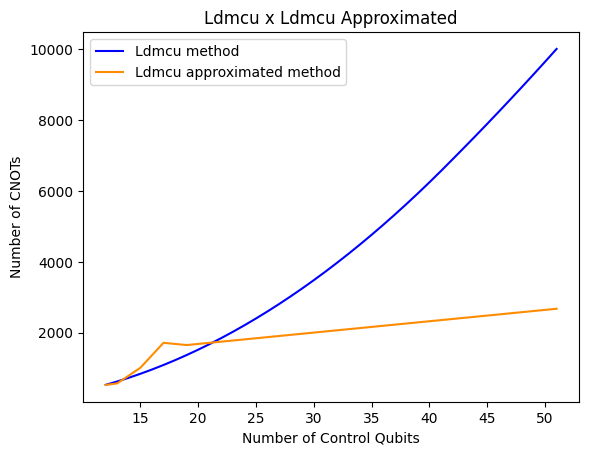

In [25]:
plt.plot(
    control_qubits, cir_real_cnots, 'b',
    control_qubits, cir_approx_cnots, 'darkorange'
)

plt.legend(
    ('Ldmcu method', 'Ldmcu approximated method'),
    loc='upper left', shadow=False
)
#plt.grid(True)
plt.title('Ldmcu x Ldmcu Approximated')
plt.xlabel('Number of Control Qubits')
plt.ylabel('Number of CNOTs')
plt.savefig("ldmcu_approx.svg", dpi=600)
plt.show()

In [ ]:
def test_mcx_comute(self):

    qiskit_circuit1 = QuantumCircuit(8)
    qiskit_circuit2 = QuantumCircuit(8)
    controls_idx = list(np.arange(4))
    qiskit_circuit1.mcx(controls_idx, [6])
    qiskit_circuit2.mcx(controls_idx, [7])

    qiskit_mcx_op1 = Operator(qiskit_circuit1).data
    qiskit_mcx_op2 = Operator(qiskit_circuit2).data

    a = qiskit_mcx_op1 @ qiskit_mcx_op2
    b = qiskit_mcx_op2 @ qiskit_mcx_op1
    self.assertTrue(
        np.allclose(a, b)
    )

## Comparação mxc

In [4]:
u = np.array([[0,1], [1,0]])
error=1e-3
ldmcu_approx_dummy = LdmcuApprox(u, num_controls=100, error=error)
base_ctrl_qubits_mcx = ldmcu_approx_dummy._get_num_base_ctrl_qubits(u,error)
print(base_ctrl_qubits_mcx)

12


In [7]:
cnot_approx=[]
cnot_original = []
base_limit = base_ctrl_qubits_mcx+25
for n_controls in range(base_ctrl_qubits_mcx, base_limit):

    controls = QuantumRegister(n_controls)
    target = QuantumRegister(1)
    circuit_approx = QuantumCircuit(controls, target)
    LdmcuApprox.ldmcu_approx(circuit_approx, u, controls, target, error)

    cnot_approx.append(get_cnot_count(circ=circuit_approx))
    circuit_og = QuantumCircuit(controls, target)
    Ldmcu.ldmcu(circuit_og, u, controls, target)
    cnot_original.append(get_cnot_count(circ=circuit_og))

print(get_cnot_count(circ=circuit_og))
print(get_cnot_count(circ=circuit_approx))

5042
2196


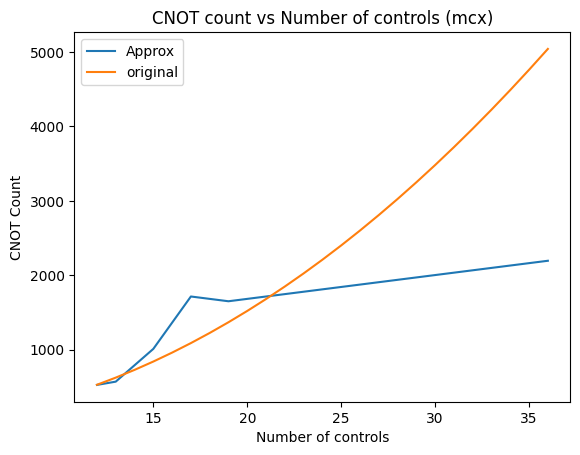

In [73]:
# x = list(range(base_ctrl_qubits_mcx, base_ctrl_qubits_mcx+100,10))
# cnot_approx_x_plot = [224, 2324, 4564, 6804, 9044, 11284, 13524, 15764, 18004, 20244]
# cnot_original_x_plot = [226, 1226, 3026, 5626, 9026, 13226, 18226, 24026, 30626, 38026]
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
# Plot the data as a line plot
plt.plot(eixo_x, cnot_approx, label = "Approx")
plt.plot(eixo_x, cnot_original, label = "original")
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')

# Display the graph
plt.legend()
plt.show()

## Comparação analítica

In [39]:
def custo_og(eta, m):
    return 4*(eta+m)**2 -12*(eta+m)+10

def custo_approx(eta,m):
    return 4*(eta-2)**2 + 2*(eta-2) * (16*m-8)

def custo_otimizado(eta, m):
    return 4*(eta-2)**2 + 64*eta - 304 + 32*(eta + m)

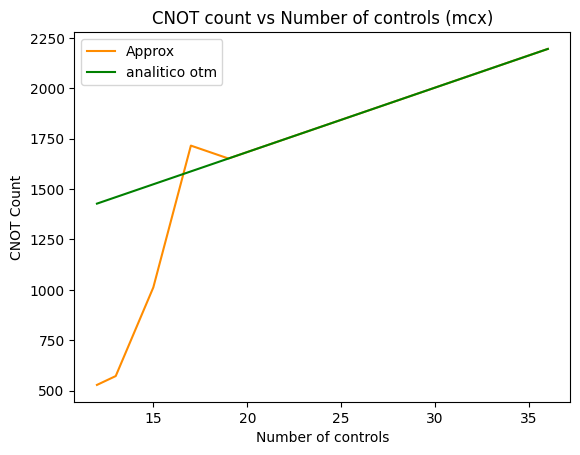

In [21]:
# x = list(range(base_ctrl_qubits_mcx, base_ctrl_qubits_mcx+100,10))
# cnot_approx_x_plot = [224, 2324, 4564, 6804, 9044, 11284, 13524, 15764, 18004, 20244]
# cnot_original_x_plot = [226, 1226, 3026, 5626, 9026, 13226, 18226, 24026, 30626, 38026]
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
n_base = base_ctrl_qubits_mcx
analitico_otimizado_z_plot = [custo_otimizado(n_base, xi-n_base) for xi in eixo_x]
# Plot the data as a line plot
plt.plot(eixo_x, cnot_approx, 'darkorange',label = "Approx")
#plt.plot(eixo_x, cnot_original, 'b', label = "original")
plt.plot(eixo_x, analitico_otimizado_z_plot, 'g', label = "analitico otm")
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

plt.legend(
    ('Aproximado', 'teorema 3'),
    loc='upper left', shadow=False
)

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')
plt.savefig('comparacao_analito_numerico.svg', dpi=600)
# Display the graph
plt.legend()
plt.show()

In [24]:
for i,e in enumerate (cnot_approx):
    if i > 20:
        print(e - analitico_otimizado_z_plot[i])

0
0
0
0


## Matriz aleatória unitária de ordem 2

In [23]:
from scipy.stats import unitary_group

In [46]:
def theorem_1(n_b, n_c):
    return -28 * n_b**2 + 32 * n_b + 48 + 32 * (n_b - 2) * n_c

def theorem_2(n_t, n_c):
    return 16*(n_c +1) - 40 + 48*(n_t - 1)

In [36]:
u = unitary_group.rvs(2)
print(u)
error=1e-3
ldmcu_approx_dummy = LdmcuApprox(u, num_controls=100, error=error)
base_ctrl_qubits_mcx = ldmcu_approx_dummy._get_num_base_ctrl_qubits(u,error)

cnot_approx=[]
cnot_original = []
base_limit = base_ctrl_qubits_mcx+25
for n_controls in range(base_ctrl_qubits_mcx, base_limit):

    controls = QuantumRegister(n_controls)
    target = QuantumRegister(1)
    circuit_approx = QuantumCircuit(controls, target)
    LdmcuApprox.ldmcu_approx(circuit_approx, u, controls, target, error)

    cnot_approx.append(get_cnot_count(circ=circuit_approx))
    circuit_og = QuantumCircuit(controls, target)
    Ldmcu.ldmcu(circuit_og, u, controls, target)
    cnot_original.append(get_cnot_count(circ=circuit_og))

print(get_cnot_count(circ=circuit_og))
print(get_cnot_count(circ=circuit_approx))

[[ 0.85923166+0.48527596j  0.16167348+0.00948024j]
 [ 0.15972591+0.0267549j  -0.94571132+0.28178345j]]
5042
2196


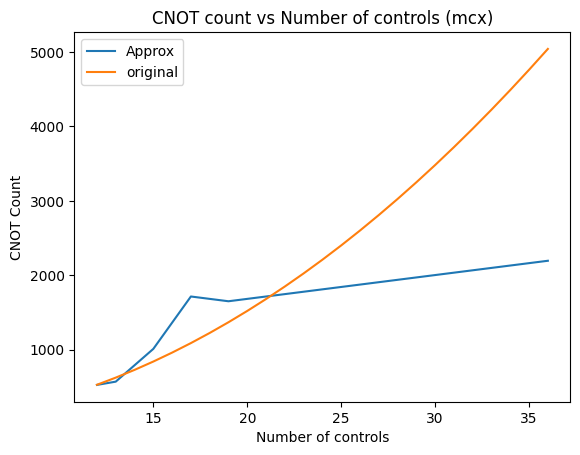

In [37]:
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
plt.plot(eixo_x, cnot_approx, label = "Approx")
plt.plot(eixo_x, cnot_original, label = "original")

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')

# Display the graph
plt.legend()
plt.show()

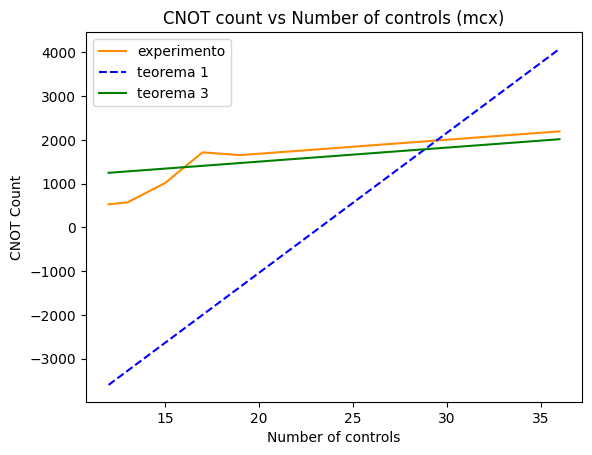

In [45]:
eixo_x = list(range(base_ctrl_qubits_mcx, base_limit))
n_base = base_ctrl_qubits_mcx
analitico_otimizado_z_plot = [custo_otimizado(n_base, xi-n_base) for xi in eixo_x]

# teorema 1
theorem_1_plot = [theorem_1(n_base, xi-n_base) for xi in eixo_x]

# Plot the data as a line plot
plt.plot(eixo_x, cnot_approx, 'darkorange',label = "experimento")
#plt.plot(eixo_x, cnot_original, 'b', label = "original")
plt.plot(eixo_x, theorem_1_plot, 'b--', label = "teorema 1")
plt.plot(eixo_x, analitico_otimizado_z_plot, 'g', label = "teorema 3")
# plt.plot(x, cnot_approx_x_plot, label = "Approx")
# plt.plot(x, cnot_original_x_plot, label = "Original")

plt.legend(
    ('Aproximado', 'teorema 1','teorema 3'),
    loc='upper left', shadow=False
)

# Add labels to the axes and a title to the graph
plt.xlabel('Number of controls')
plt.ylabel('CNOT Count')
plt.title('CNOT count vs Number of controls (mcx)')
#plt.savefig('comparacao_analito_numerico.svg', dpi=600)
# Display the graph
plt.legend()
plt.show()